In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5e/03/15cd49e855c62226ecf1831bbe4c8e73a4324856077a23c495538a36e557/xgboost-3.0.0-py3-none-win_amd64.whl.metadata
  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 262.6 kB/s eta 0:09:32
   ---------------------------------------- 0.0/150.0 MB 393.8 kB/s eta 0:06:21
   ---------------------------------------- 0.1/150.0 MB 521.8 kB/s eta 0:04:48
   ---------------------------------------- 0.1/150.0 MB 654.9 kB/s eta 0:03:49
   ---------------------------------------- 0.2/150.0 MB 701.4 kB/s eta 0:03:34
   ---------------------------------------- 0.2/150.0 MB 731.4 kB/s eta 0:03:25
   ---------------------------------------- 0.3/150.0 MB 883.3 kB/s eta 0:02:50
   --------------------

In [5]:
# Load data
df = pd.read_csv("C:/Users/admin/Desktop/Retail_Transactions_Dataset.csv")  # Replace with your file path
print(df.head())  # Check first 5 rows
print(df.info())  # Check data types and missing values

   Transaction_ID              Date      Customer_Name  \
0      1000000000  21-01-2022 06:27       Stacey Price   
1      1000000001  01-03-2023 13:01   Michelle Carlson   
2      1000000002  21-03-2024 15:37        Lisa Graves   
3      1000000003  31-10-2020 09:59  Mrs. Patricia May   
4      1000000004  10-12-2020 00:59     Susan Mitchell   

                                             Product  Total_Items  Total_Cost  \
0        ['Ketchup', 'Shaving Cream', 'Light Bulbs']            3       71.65   
1  ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...            2       25.93   
2                                        ['Spinach']            6       41.49   
3                             ['Tissues', 'Mustard']            1       39.34   
4                                      ['Dish Soap']           10       16.42   

   Payment_Method           City        Store_Type  Discount_Applied  \
0  Mobile Payment    Los Angeles    Warehouse Club              True   
1            Cash  S

In [6]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Convert 'purchase_date' to datetime
df['Date'] = pd.to_datetime(df['Date'])



C:\Users\admin\AppData\Local\Temp\ipykernel_10232\2957681455.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [8]:
# Set a reference date (e.g., last date in dataset + 1 day)
snapshot_date = df['Date'].max() + pd.Timedelta(days=1)

# Group by customer and calculate RFM metrics
rfm = df.groupby('Customer_Name').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,  # Recency (days since last purchase)
    'Transaction_ID': 'count',                                      # Frequency (number of transactions)
    'Total_Cost': 'sum'                                        # Total Spend (LTV)
}).rename(columns={
    'Date': 'recency',
    'Transaction_ID': 'frequency',
    'Total_Cost': 'total_spend'
})

# Calculate Average Order Value (AOV)
rfm['aov'] = rfm['total_spend'] / rfm['frequency']

# Reset index
rfm.reset_index(inplace=True)
print(rfm.head())

     Customer_Name  recency  frequency  total_spend        aov
0    Aaron Acevedo     1050          1        78.20  78.200000
1     Aaron Acosta     1392          1        90.77  90.770000
2      Aaron Adams      978          2       169.27  84.635000
3    Aaron Aguilar       57          3       180.61  60.203333
4  Aaron Alexander      248          1        14.78  14.780000


In [9]:
# Define features (X) and target (y)
X = rfm[['recency', 'frequency', 'aov']]
y = rfm['total_spend']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model (or Random Forest)
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 0.6806533879514636
RMSE: 3.269452583382326


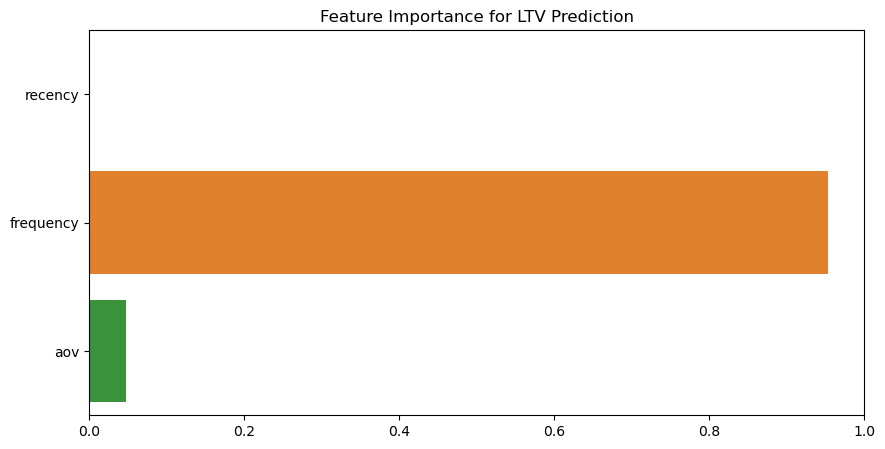

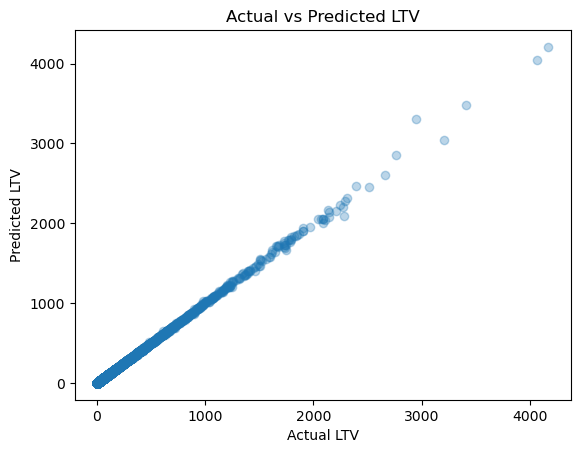

In [13]:
# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance for LTV Prediction")
plt.show()

# Scatter plot of actual vs predicted LTV
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV")
plt.show()

In [14]:
# Add predictions back to the RFM dataframe
rfm['predicted_ltv'] = model.predict(X)

# Segment customers into High/Medium/Low LTV
rfm['ltv_segment'] = pd.qcut(rfm['predicted_ltv'], q=3, labels=['Low', 'Medium', 'High'])
print(rfm.groupby('ltv_segment').size())

ltv_segment
Low       56052
Medium    55702
High      55603
dtype: int64


In [16]:
# Save predictions to CSV
rfm.to_csv("C:/Users/admin/Downloads/customer_ltv_predictions.csv", index=False)